In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nilearn.plotting import plot_design_matrix
import statsmodels.api as sm

sys.path.append('/Users/jeanettemumford/Dropbox/Research/Projects/patrick/efficiency_rdoc')

%load_ext autoreload
%autoreload 2
from utils import (calc_expected_run_num_by_chance, sample_shifted_truncated_exponential, 
                   est_eff_and_vif, est_psych_fitness, run_eff_sim, calc_avg_prob_next_given_last1_and_last2)

This is the design we settled on
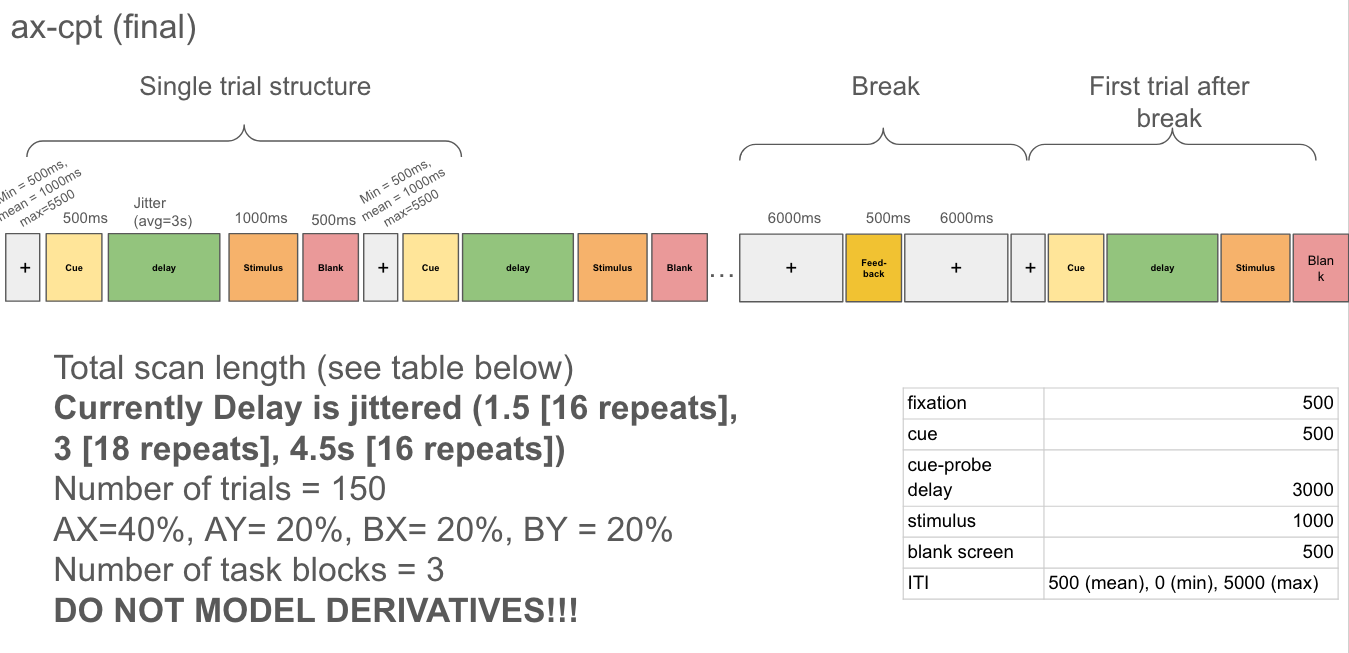

In [2]:
def make_ax_cpt_timings(n_ax, n_ay, n_bx, n_by, cue_dur, delay_dur, stim_dur, blank_dur,  
                             nbreaks, break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift):
    '''
    Produces a randomly ordered set of trials for the ax-cpt task.
    Assumes a break between blocks of task.  Number of ax/ay/bx/by trials will be equal
    for each block of the task 
    ISI is sampled from a truncated exponential.  Note the truncation value for the
    truncated exponential does *not* include the shift, so the max isi is
    isi_truncation + isi_shift.
    A trial is structured as:
      fixation (based on truncated exponential) + 
      cue(cue_dur) + delay (delay_dur) + stimulus (stim_dur) + blank (blank_dur) + 
      next trial (same structure as above until end of block is reached)
      At end of block the break begins with:
      fixation (length=break_dur) + 
      break message (break_message_dur) + 
      post message fixation (post_message_dur)
    Input:
      n_ax, n_ay, n_bx, n_by: Total number of ax/bx/ax/ay trials 
          (will be evenly split between blocks) Integer divisible by (nbreaks + 1)
      stop_dur: Duration of a stop trial
      cue_dur/delay_dur/stim_dur/blank_dur: Durations of cue/delay/stim/blank
      blank_dur:  Duration of blank screen after stop/go stimulus offset
      break_fix_pre_message_dur: Fixation duration at beginning of break (no jittering)
      break_message_dur:  Duration of message shown during break
      break_fix_post_message_dur:  Fixation duration after message (no jittering)
      isi_exp_lam:  (seconds) The lambda parameter of the exponential used for the isi 
                    (inverse is the non-truncated/non-shifted mean)
      isi_truncation: (seconds) Truncation value of the exponential *NOT* including shift.  
                      Max ISI = isi_truncation + isi_shift
      isi_shift: (seconds) Shift value for isi (minimum isi value)
    Output:
       Events pandas data frame with onsets, trial_type and duration.  
    '''
    
    nblocks = nbreaks + 1
    ntrials = n_ax + n_ay + n_bx + n_by
    ntrials_per_block = int(ntrials/nblocks)
    n_ax_per_block = int(n_ax / (nblocks))
    n_ay_per_block = int(n_ay / (nblocks))
    n_bx_per_block = int(n_bx / (nblocks))
    n_by_per_block = int(n_by / (nblocks))
    isi_vals, _ = sample_shifted_truncated_exponential(isi_exp_lam, isi_truncation, 
                                                    isi_shift, ntrials)

    # Each stimulus has 3 fragments and each break has 3 fragments
    isi_count = 0
    fragment_durations = []
    fragment_labels = []
    for cur_block in range(nblocks):
        stim_type_block = np.random.permutation(np.concatenate((np.repeat(['ax'], n_ax_per_block),
                                                        np.repeat(['ay'], n_ay_per_block),
                                                        np.repeat(['bx'], n_bx_per_block),
                                                        np.repeat(['by'], n_by_per_block))))
        #ntrials_per_block will usually be 50, which isn't divisible by 3, so I add two 3s long trials
        delays_block_jitter3 = np.concatenate((np.repeat([1.5, 3, 4.5], ntrials_per_block/3), [3,3]))
        np.random.shuffle(delays_block_jitter3)
        delays_block_jitter2 = np.concatenate((np.repeat([.5, 2, 3.5], ntrials_per_block/3), [2, 2]))
        np.random.shuffle(delays_block_jitter2)
        for cur_trial in range(ntrials_per_block):
            cur_stim_type = stim_type_block[cur_trial]
            if delay_dur == 'jittered3':
                #delay_dur_loop = np.random.uniform(low=1.5, high=4.5, size=1)[0]
                delay_dur_loop = delays_block_jitter3[cur_trial]
            elif delay_dur == 'jittered2':
                delay_dur_loop = delays_block_jitter2[cur_trial]
            else:
                delay_dur_loop = delay_dur
            fragment_durations.extend([isi_vals[isi_count], cue_dur, delay_dur_loop, stim_dur, blank_dur])
            fragment_labels.extend(['isi_fix', f'cue_{cur_stim_type}', 'delay', f'stim_{cur_stim_type}', 'blank'])
            isi_count = isi_count + 1
        #Add break
        fragment_durations.extend([break_fix_pre_message_dur, break_message_dur, break_fix_post_message_dur])
        fragment_labels.extend(['fix_break', 'break_message', 'fix_break'])

    # If you don't want the beginning of the run to start at 0, change this 
    # (e.g. if you want to add the 10s to reach steady state)
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]       
    events_data = pd.DataFrame({'onset': fragment_onsets,
                                'trial_type': fragment_labels,
                                'duration': fragment_durations})
    string_replace_dict = {'cue_bx': 'cue_b', 
                           'cue_by': 'cue_b',
                           'cue_ax': 'cue_a',
                           'cue_ay': 'cue_a'}
    events_data['trial_type'] = events_data['trial_type'].replace(string_replace_dict)
    events_data = events_data.loc[events_data['trial_type'].str.contains('cue|stim|delay|break_message')==True]
    return events_data

In [3]:
events_inputs = {
    'n_ax': 60,
    'n_ay': 30,
    'n_bx': 30,
    'n_by': 30,
    'nbreaks': 2,
    'cue_dur': .5,
    'delay_dur': 3,
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

tr = 1.49
total_time = 19*60
contrasts = {'cue_a-cue_b': 'cue_a - cue_b',
             'stim_ay-stim_by': 'stim_ay-stim_by',
             'stim_bx-stim_by': 'stim_bx-stim_by',
             'all_cue': '.5*cue_a + .5*cue_b',
             'all_stim': '.25*stim_ax + .25*stim_ay + .25*stim_bx + .25*stim_by',
             'all_cue_stim': '1/6*cue_a +  1/6*cue_b + 1/6*stim_ax + 1/6*stim_ay + 1/6*stim_bx + 1/6*stim_by'
             }




In [4]:
# This variable is used later to pull out rows of of the events file and translate
# names into the string integers used to assess the psychological factors
trials_psych_assess_map = {'stim_ax': '1', 'stim_ay': '2', 'stim_bx': '3', 'stim_by': '4'}

unpermuted_trials = np.concatenate([np.repeat('1', events_inputs['n_ax']/3), 
                                    np.repeat('2', events_inputs['n_ay']/3),
                                    np.repeat('3', events_inputs['n_bx']/3), 
                                    np.repeat('4', events_inputs['n_by']/3)],
                                    axis=0)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1', '2', '3', '4']:
    avg_trial_repeats_info[f'{val}_run_counts'] = avg_trial_repeats_info[f'{val}_run_counts'] * 3
print(avg_trial_repeats_info)

avg_prob_given_last1, avg_prob_given_last2 = calc_avg_prob_next_given_last1_and_last2(unpermuted_trials)
print(avg_prob_given_last1)
print(avg_prob_given_last2)

    run_length  1_run_counts  2_run_counts  3_run_counts  4_run_counts
0          1.0       21.9960       19.5402       19.5708       19.6452
1          2.0        8.9760        3.8016        3.7728        3.7614
2          3.0        3.4716        0.6438        0.6456        0.6234
3          4.0        1.2648        0.0906        0.1032        0.1032
4          5.0        0.4554        0.0132        0.0108        0.0102
5          6.0        0.1680        0.0000        0.0036        0.0006
6          7.0        0.0468        0.0000        0.0006        0.0000
7          8.0        0.0168        0.0000        0.0000        0.0000
8          9.0        0.0072        0.0000        0.0000        0.0000
9         10.0        0.0018        0.0000        0.0000        0.0000
10        11.0        0.0006        0.0000        0.0000        0.0000
11        12.0        0.0000        0.0000        0.0000        0.0000
12        13.0        0.0000        0.0000        0.0000        0.0000
13    

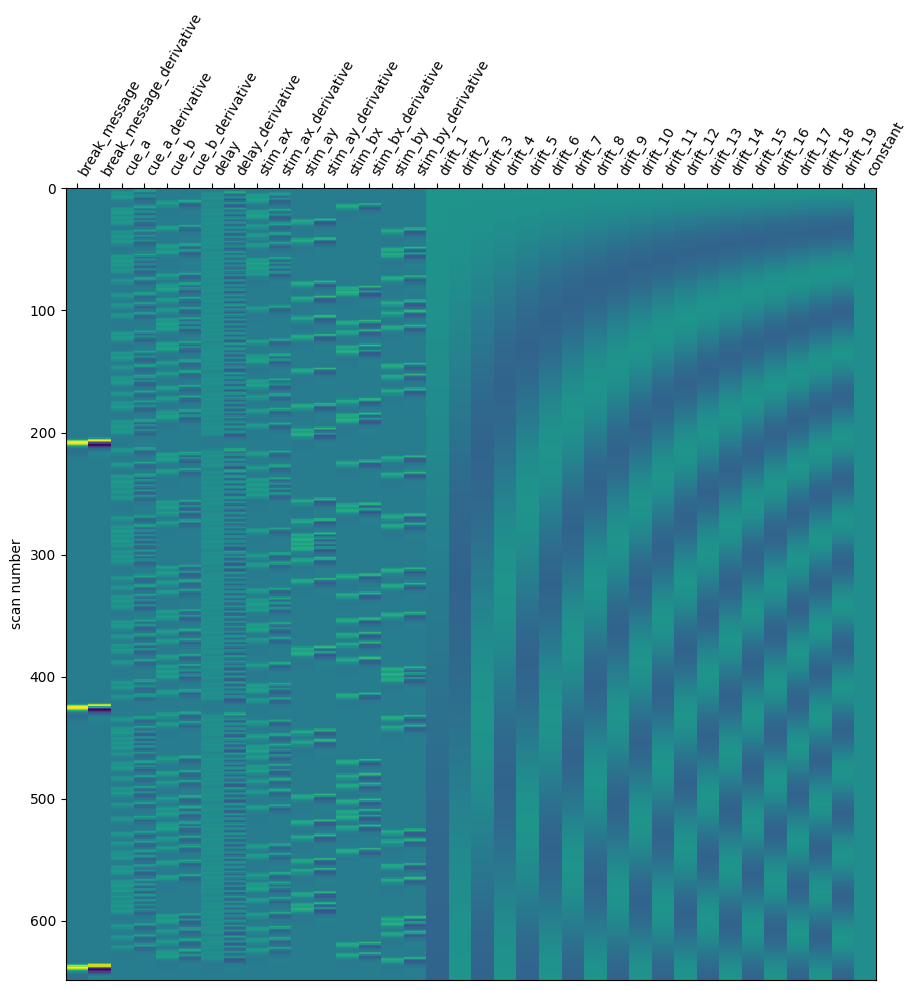

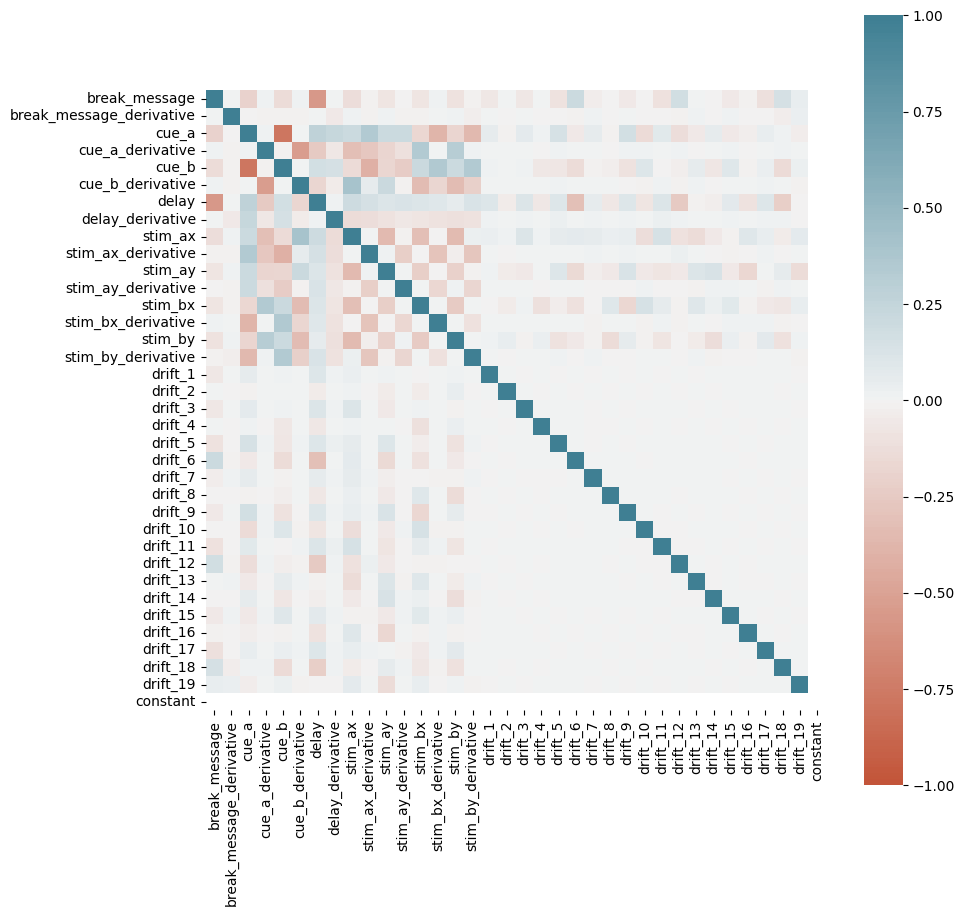

In [7]:
events_cpt = make_ax_cpt_timings(**events_inputs)
_, _, desmat = est_eff_and_vif(events_cpt, tr, total_time, contrasts)

plot_design_matrix(desmat)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [8]:
nsim = 250
output_setting1, events_setting1 = run_eff_sim(nsim, events_inputs, make_ax_cpt_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, avg_prob_given_last1, avg_prob_given_last2,
                               time_past_last_offset=20)

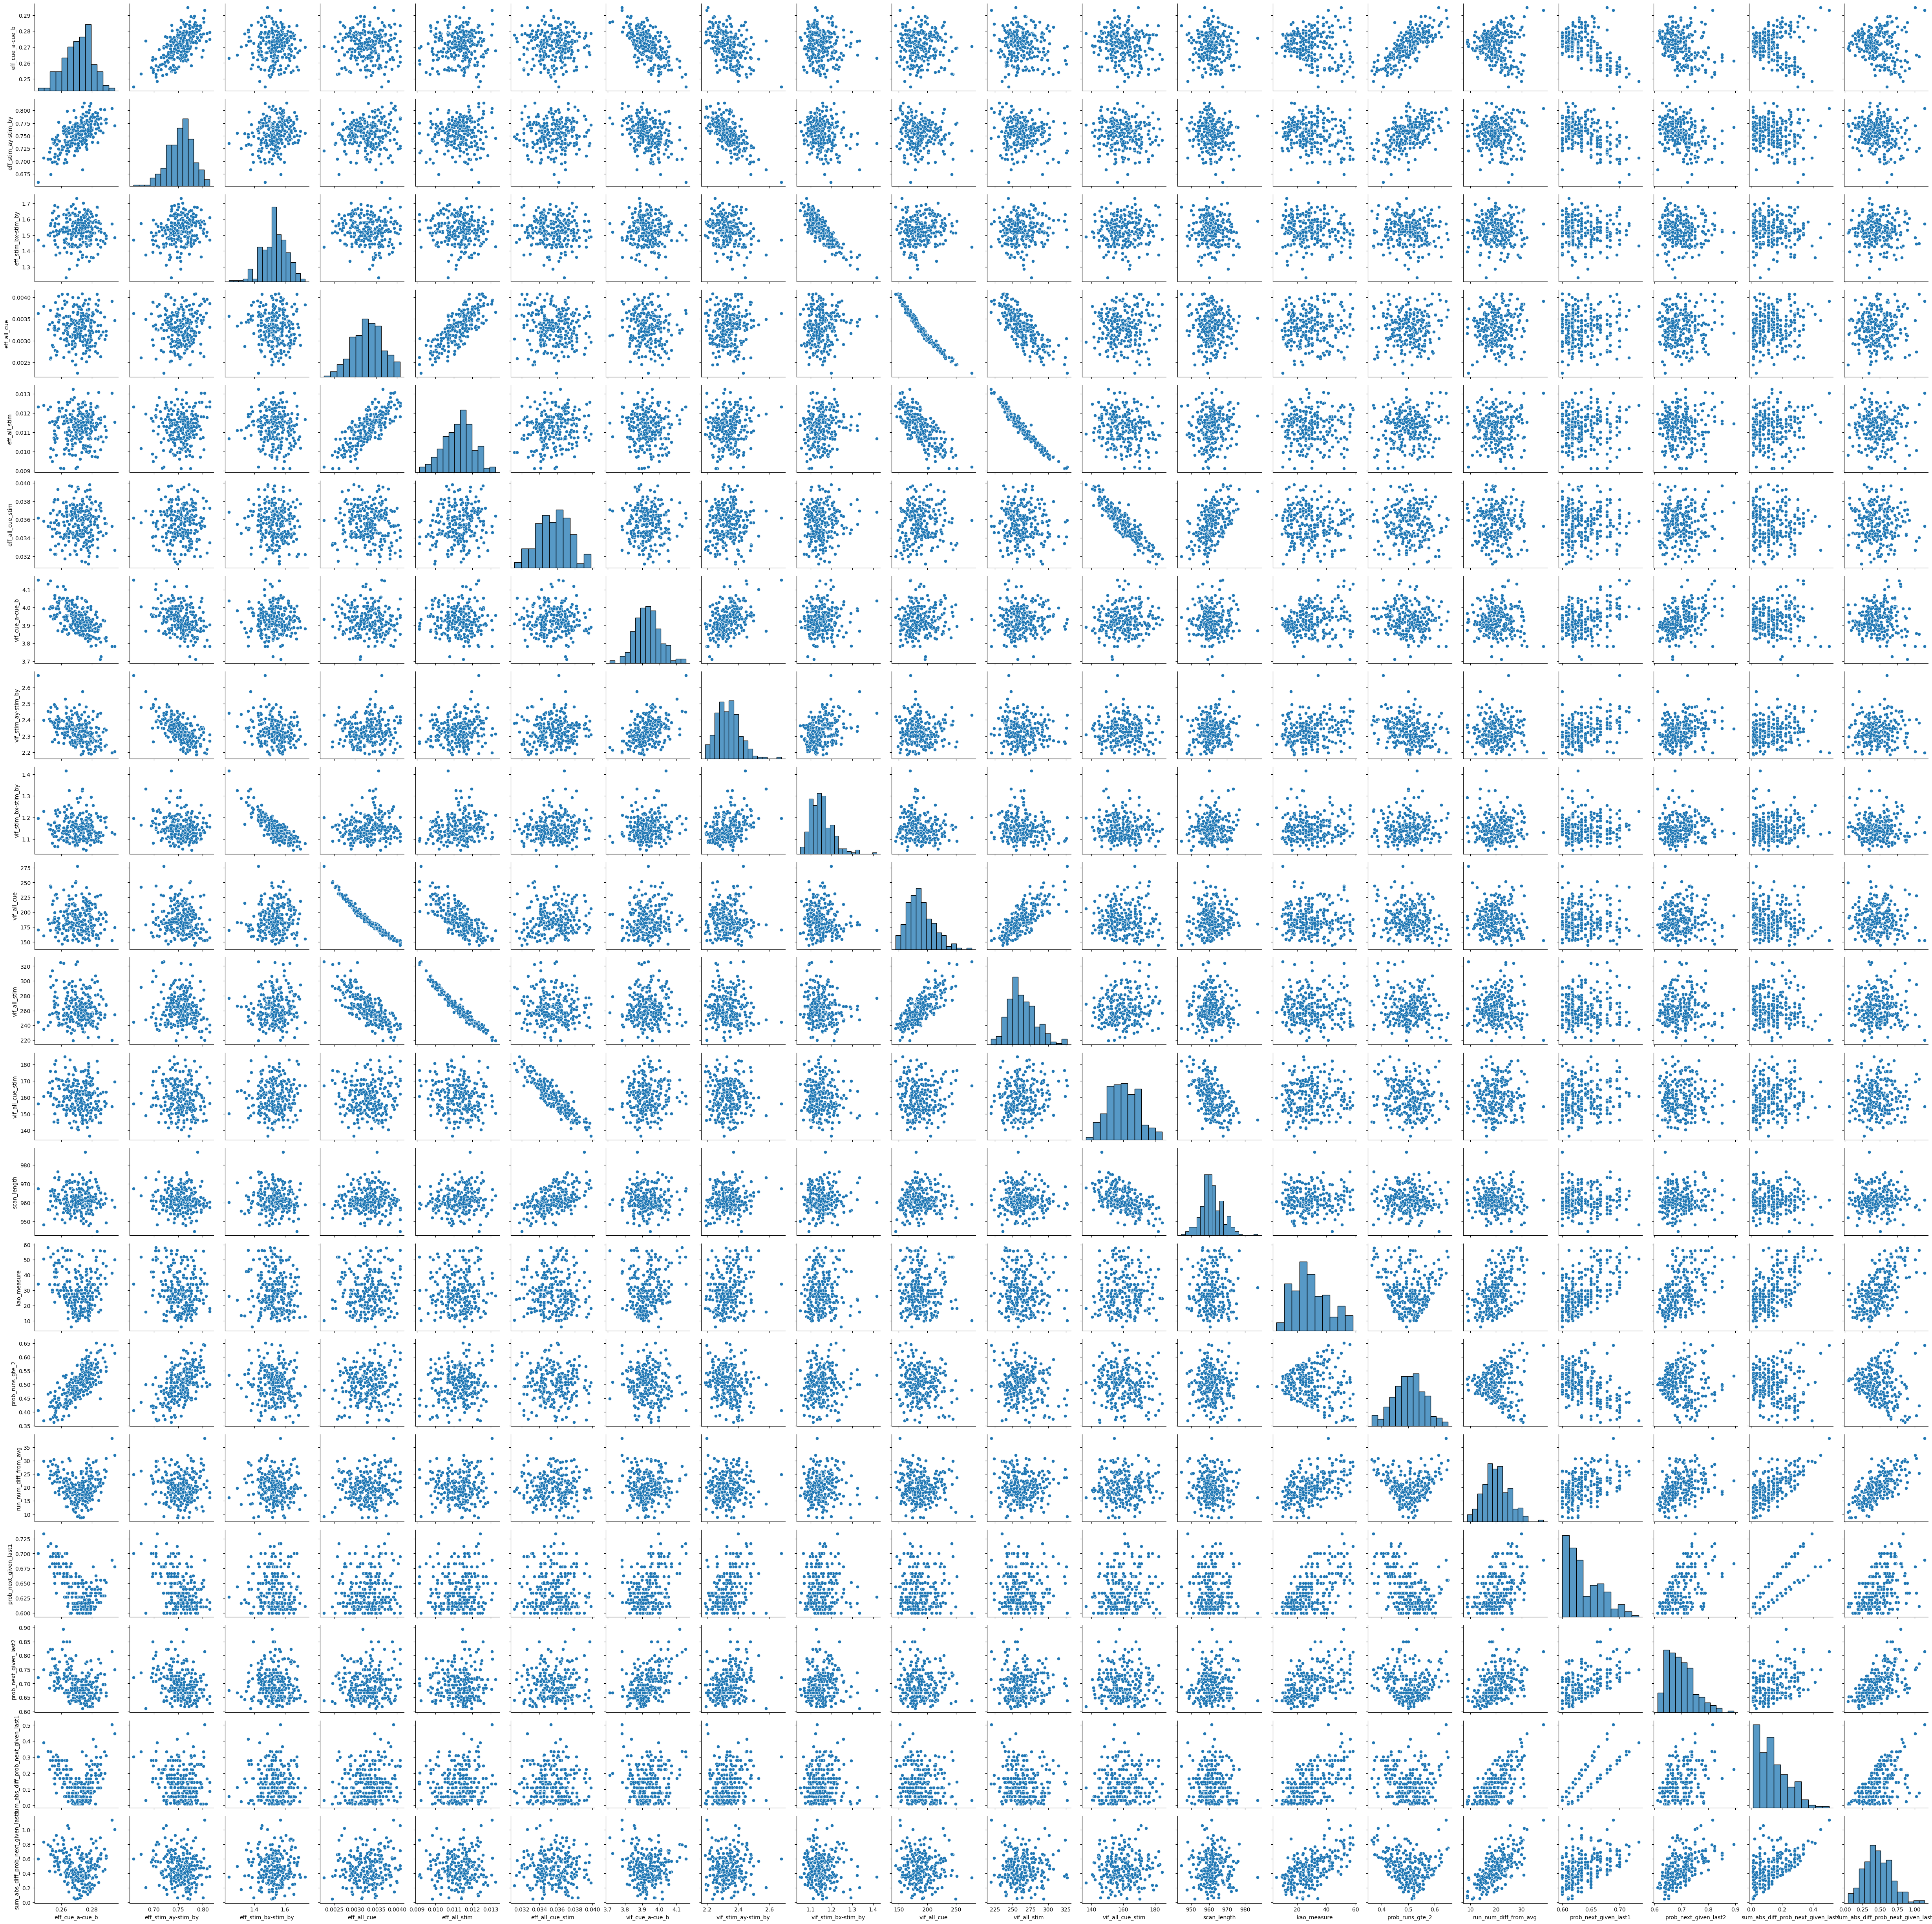

In [9]:
g = sns.PairGrid(output_setting1)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)


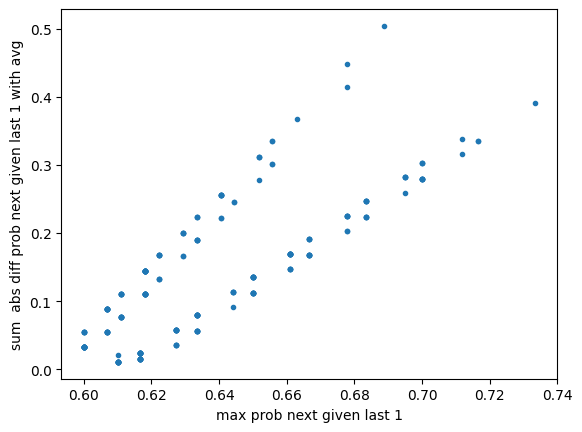

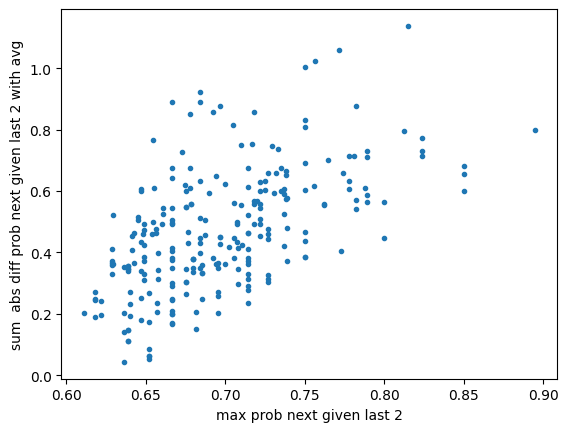

In [10]:
plt.plot(output_setting1['prob_next_given_last1'], output_setting1['sum_abs_diff_prob_next_given_last1'], '.')
plt.xlabel('max prob next given last 1')
plt.ylabel('sum  abs diff prob next given last 1 with avg')
plt.show()

plt.plot(output_setting1['prob_next_given_last2'], output_setting1['sum_abs_diff_prob_next_given_last2'], '.')
plt.xlabel('max prob next given last 2')
plt.ylabel('sum  abs diff prob next given last 2 with avg')
plt.show()

In [11]:
pd.set_option('display.width', 1000)
eff_vif_summaries = {}

eff_vif_summaries['setting1']= np.round(output_setting1[['eff_cue_a-cue_b', 'eff_stim_ay-stim_by', 
                                                         'eff_stim_bx-stim_by','eff_all_cue', 'eff_all_stim', 'eff_all_cue_stim',
                                                         'vif_cue_a-cue_b', 'vif_stim_ay-stim_by', 
                                                         'vif_stim_bx-stim_by','vif_all_cue', 'vif_all_stim', 'vif_all_cue_stim',
                                                         'scan_length']].quantile(q=[.05, .5, .95]), 2)

print('95th percentile of efficiencies')
print(eff_vif_summaries['setting1'])

95th percentile of efficiencies
      eff_cue_a-cue_b  eff_stim_ay-stim_by  eff_stim_bx-stim_by  eff_all_cue  eff_all_stim  eff_all_cue_stim  vif_cue_a-cue_b  vif_stim_ay-stim_by  vif_stim_bx-stim_by  vif_all_cue  vif_all_stim  vif_all_cue_stim  scan_length
0.05             0.26                 0.71                 1.39          0.0          0.01              0.03             3.83                 2.22                 1.09       155.60        236.50            145.20       951.72
0.50             0.27                 0.76                 1.53          0.0          0.01              0.04             3.93                 2.33                 1.14       184.41        260.47            159.81       960.93
0.95             0.28                 0.80                 1.66          0.0          0.01              0.04             4.05                 2.46                 1.24       228.90        298.49            176.35       971.64


### Shorten the delay from 3s to 2s

In [12]:
# Change delay dur from 3s to 2s
events_inputs_delay2s = {
    'n_ax': 60,
    'n_ay': 30,
    'n_bx': 30,
    'n_by': 30,
    'nbreaks': 2,
    'cue_dur': .5,
    'delay_dur': 2,
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}



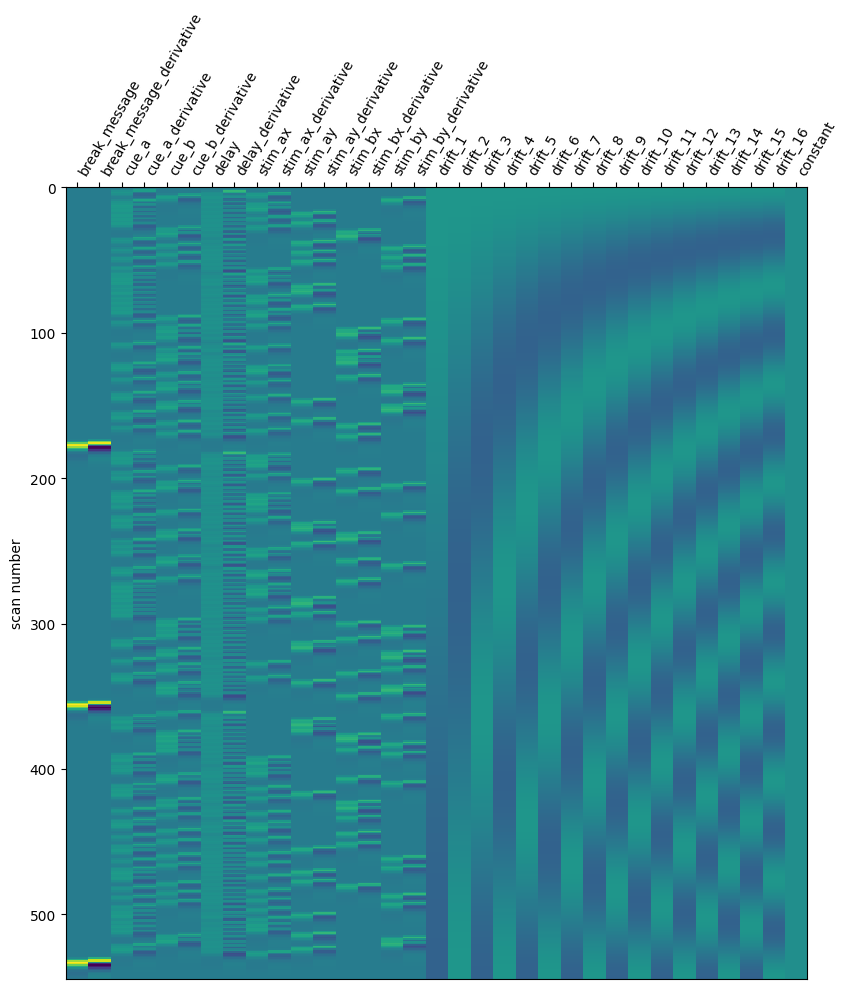

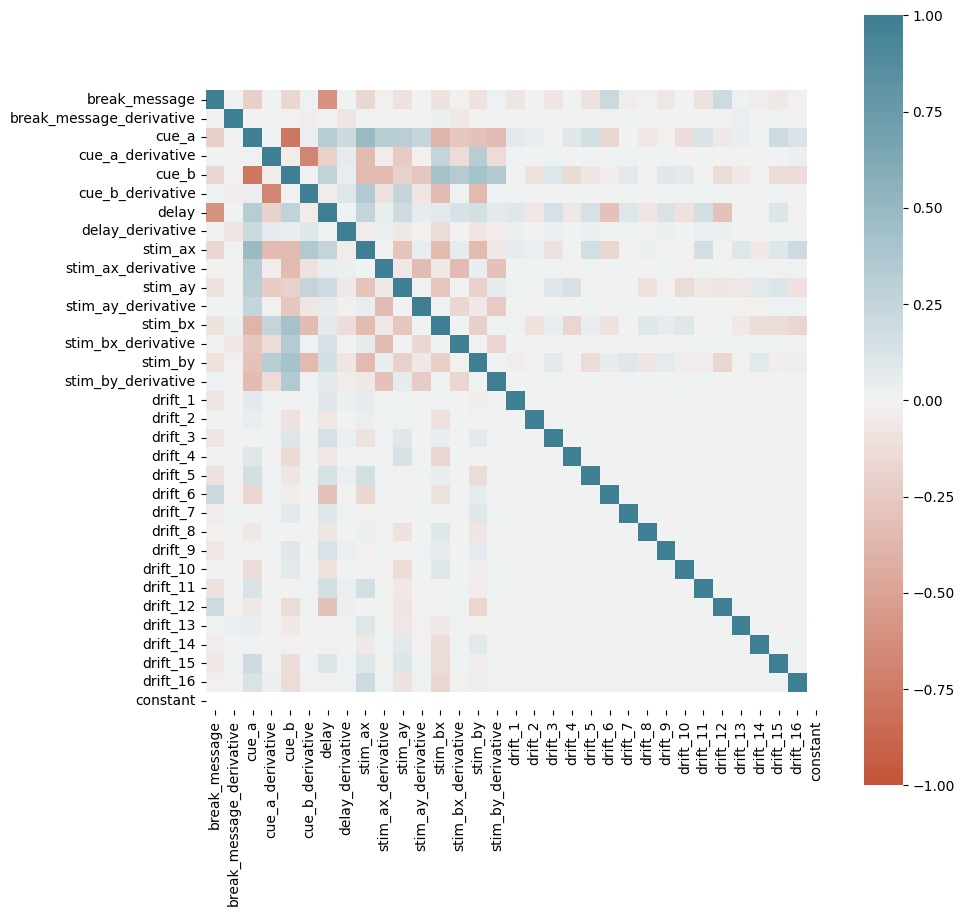

In [13]:
events_cpt_delay2s = make_ax_cpt_timings(**events_inputs_delay2s)
_, _, desmat_delay2s = est_eff_and_vif(events_cpt_delay2s, tr, total_time, contrasts)

plot_design_matrix(desmat_delay2s)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat_delay2s.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [14]:
nsim = 250
output_delay2s, events_delay2s = run_eff_sim(nsim, events_inputs_delay2s, make_ax_cpt_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, avg_prob_given_last1, avg_prob_given_last2,
                               time_past_last_offset=20)

In [15]:
eff_vif_summaries['shorter delay(2s)']= np.round(output_delay2s[['eff_cue_a-cue_b', 'eff_stim_ay-stim_by', 
                                                         'eff_stim_bx-stim_by','eff_all_cue', 'eff_all_stim', 'eff_all_cue_stim',
                                                         'vif_cue_a-cue_b', 'vif_stim_ay-stim_by', 
                                                         'vif_stim_bx-stim_by','vif_all_cue', 'vif_all_stim', 'vif_all_cue_stim',
                                                         'scan_length']].quantile(q=[.05,.5, .95]), 2)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_cue_a-cue_b  eff_stim_ay-stim_by  eff_stim_bx-stim_by  eff_all_cue  eff_all_stim  eff_all_cue_stim  vif_cue_a-cue_b  vif_stim_ay-stim_by  vif_stim_bx-stim_by  vif_all_cue  vif_all_stim  vif_all_cue_stim  scan_length
0.05             0.26                 0.71                 1.39          0.0          0.01              0.03             3.83                 2.22                 1.09       155.60        236.50            145.20       951.72
0.50             0.27                 0.76                 1.53          0.0          0.01              0.04             3.93                 2.33                 1.14       184.41        260.47            159.81       960.93
0.95             0.28                 0.80                 1.66          0.0          0.01              0.04             4.05                 2.46                 1.24       228.90        298.49            176.35       971.64
Results for shorter delay(2s)
      eff_cue_a-cue_b  eff_stim_ay-stim_by  e

Definitely cannot go shorter (2-4 fold increase in variance!)  It is likely driven by the high correlation between cue/stimulus pairs within the same condition.  From the correlation plot it looks like the derivative terms are potentially driving collinearity of the variables of interest as well.

### Lengthen delay from 3s to 4s
Back up and try a longer ISI to see if the efficiency improves.  I realize this is unreasonable in terms of scan time, but I want to use this as a benchmark for how bad things are for the 3s delay period.

In [16]:
events_inputs_delay4s = {
    'n_ax': 60,
    'n_ay': 30,
    'n_bx': 30,
    'n_by': 30,
    'nbreaks': 2,
    'cue_dur': .5,
    'delay_dur': 4,
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

tr = 1.49
total_time = 19*60 

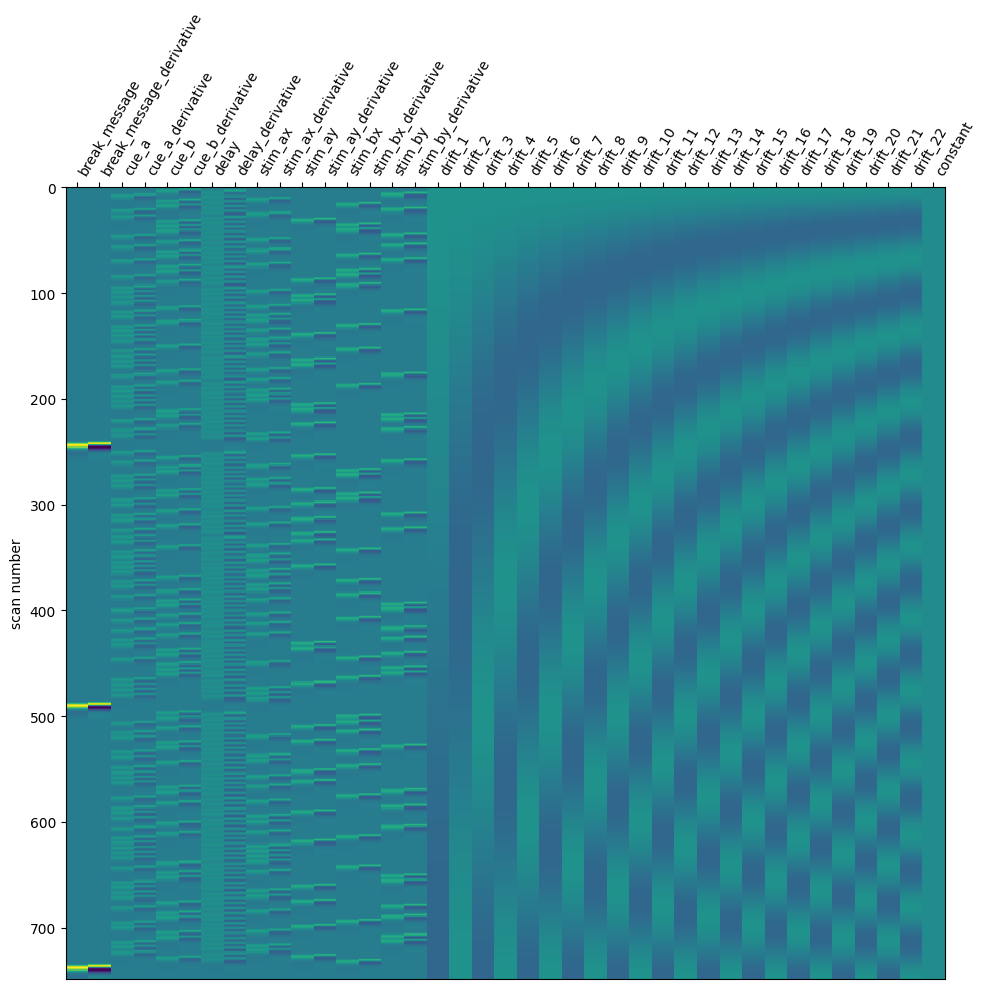

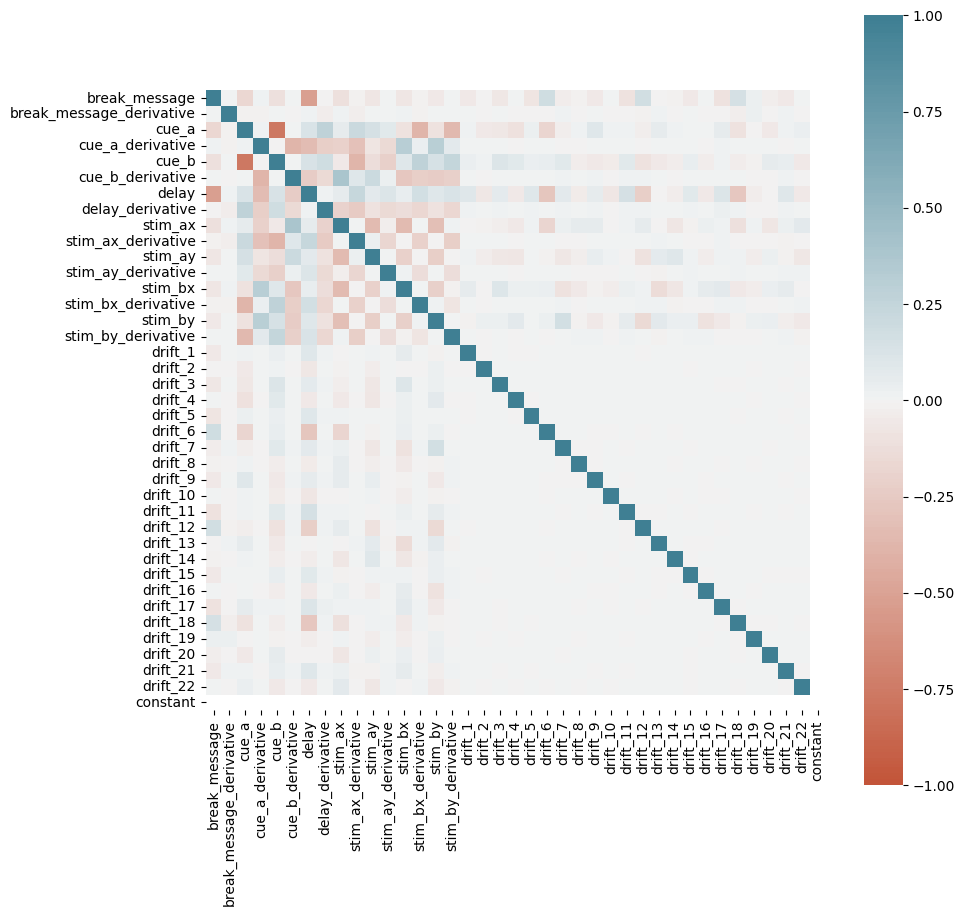

In [17]:
events_cpt_delay4s = make_ax_cpt_timings(**events_inputs_delay4s)
_, _, desmat_delay4s = est_eff_and_vif(events_cpt_delay4s, tr, total_time, contrasts)

plot_design_matrix(desmat_delay4s)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat_delay4s.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [18]:
nsim = 250
output_delay4s, events_delay4s = run_eff_sim(nsim, events_inputs_delay4s, make_ax_cpt_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, avg_prob_given_last1, avg_prob_given_last2,
                               time_past_last_offset=20)

In [19]:
eff_vif_summaries['longer delay(4s)']= np.round(output_delay4s[['eff_cue_a-cue_b', 'eff_stim_ay-stim_by', 
                                                         'eff_stim_bx-stim_by','eff_all_cue', 'eff_all_stim', 'eff_all_cue_stim',
                                                         'vif_cue_a-cue_b', 'vif_stim_ay-stim_by', 
                                                         'vif_stim_bx-stim_by','vif_all_cue', 'vif_all_stim', 'vif_all_cue_stim',
                                                         'scan_length']].quantile(q=[.05,.5, .95]), 2)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_cue_a-cue_b  eff_stim_ay-stim_by  eff_stim_bx-stim_by  eff_all_cue  eff_all_stim  eff_all_cue_stim  vif_cue_a-cue_b  vif_stim_ay-stim_by  vif_stim_bx-stim_by  vif_all_cue  vif_all_stim  vif_all_cue_stim  scan_length
0.05             0.26                 0.71                 1.39          0.0          0.01              0.03             3.83                 2.22                 1.09       155.60        236.50            145.20       951.72
0.50             0.27                 0.76                 1.53          0.0          0.01              0.04             3.93                 2.33                 1.14       184.41        260.47            159.81       960.93
0.95             0.28                 0.80                 1.66          0.0          0.01              0.04             4.05                 2.46                 1.24       228.90        298.49            176.35       971.64
Results for shorter delay(2s)
      eff_cue_a-cue_b  eff_stim_ay-stim_by  e

There is a bump in efficiencies here and the VIFs are very low.  This is likely the among the best we can do in terms of separating the cue and stimulus.  Since we're seeing approximately twice the efficiency, that means the within-subject variance for the longer delay is half as large.

### Jittering the delay (1.5, 3, or 4.5s)

In [20]:
events_inputs_delay_jitter = {
    'n_ax': 60,
    'n_ay': 30,
    'n_bx': 30,
    'n_by': 30,
    'nbreaks': 2,
    'cue_dur': .5,
    'delay_dur': 'jittered3',
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}


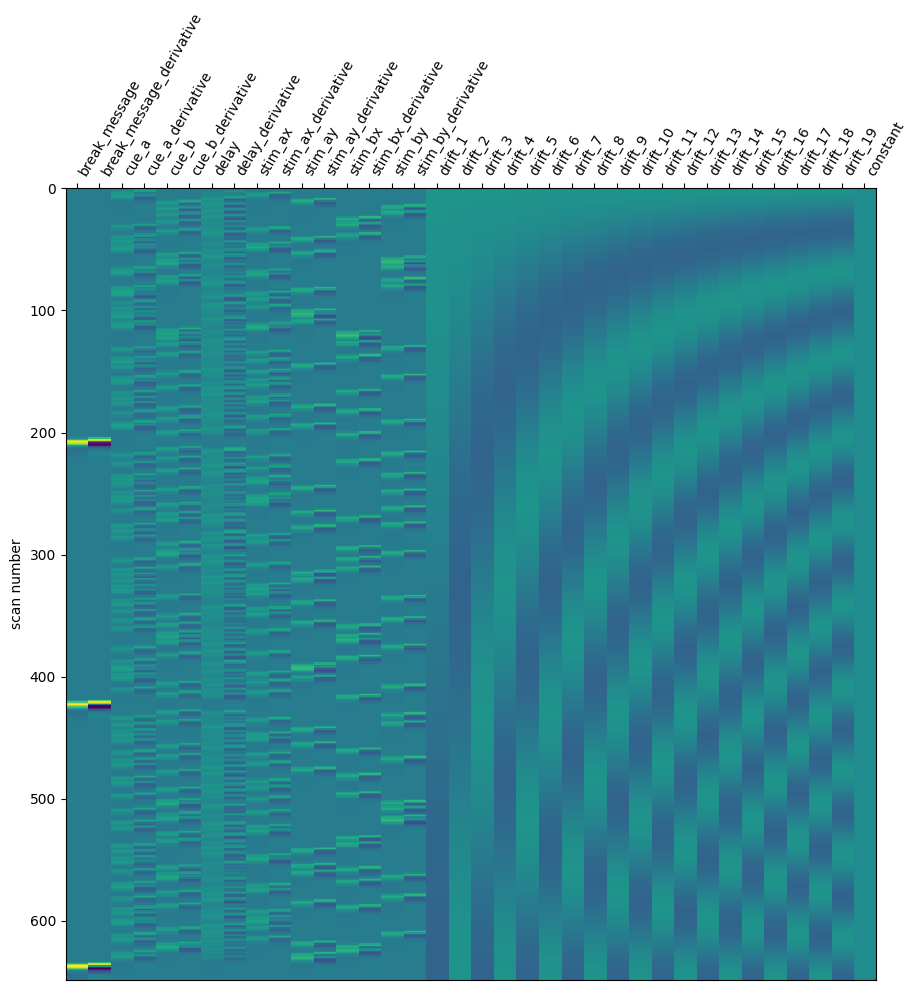

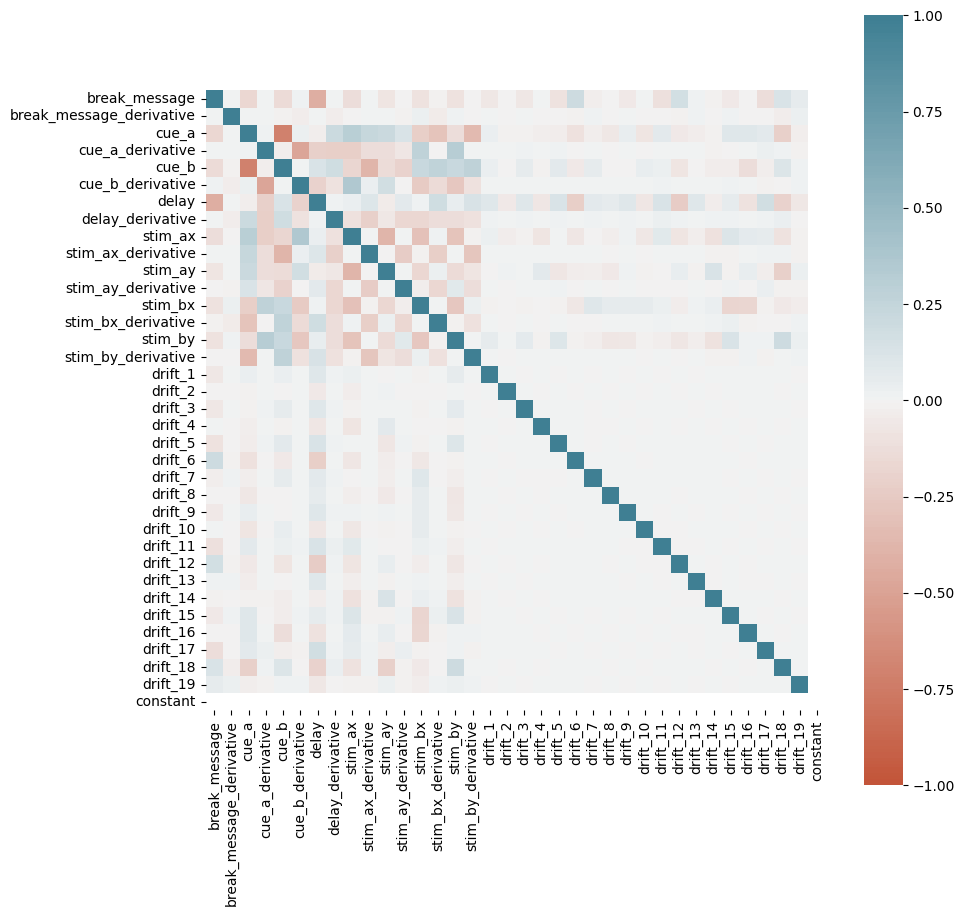

In [21]:
events_cpt_delay_jitter = make_ax_cpt_timings(**events_inputs_delay_jitter)
_, _, desmat_delay_jitter = est_eff_and_vif(events_cpt_delay_jitter, tr, total_time, contrasts)

plot_design_matrix(desmat_delay_jitter)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat_delay_jitter.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [22]:
nsim = 250
output_delay_jitter, events_delay_jitter = run_eff_sim(nsim, events_inputs_delay_jitter, make_ax_cpt_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, avg_prob_given_last1, avg_prob_given_last2,
                               time_past_last_offset=20)

In [23]:
eff_vif_summaries['delay jitter (1.5, 3, 4.5)']= np.round(output_delay_jitter[['eff_cue_a-cue_b', 'eff_stim_ay-stim_by', 
                                                         'eff_stim_bx-stim_by','eff_all_cue', 'eff_all_stim', 'eff_all_cue_stim',
                                                         'vif_cue_a-cue_b', 'vif_stim_ay-stim_by', 
                                                         'vif_stim_bx-stim_by','vif_all_cue', 'vif_all_stim', 'vif_all_cue_stim',
                                                         'scan_length']].quantile(q=[.05,.5, .95]), 2)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_cue_a-cue_b  eff_stim_ay-stim_by  eff_stim_bx-stim_by  eff_all_cue  eff_all_stim  eff_all_cue_stim  vif_cue_a-cue_b  vif_stim_ay-stim_by  vif_stim_bx-stim_by  vif_all_cue  vif_all_stim  vif_all_cue_stim  scan_length
0.05             0.26                 0.71                 1.39          0.0          0.01              0.03             3.83                 2.22                 1.09       155.60        236.50            145.20       951.72
0.50             0.27                 0.76                 1.53          0.0          0.01              0.04             3.93                 2.33                 1.14       184.41        260.47            159.81       960.93
0.95             0.28                 0.80                 1.66          0.0          0.01              0.04             4.05                 2.46                 1.24       228.90        298.49            176.35       971.64
Results for shorter delay(2s)
      eff_cue_a-cue_b  eff_stim_ay-stim_by  e

There's a slight increase in efficiency when using the jitter compared to setting1.  Since the scan length is not impacted I think the compromise here is to use the jittered strategy, as the 4s delay is unreasonable.  

### What if we omit the derivatives?
I see there's some collinearity between the cue regressors and derivative for stimulus and stimulus with derivative for cue.  In this case we can potentially omit the derivative regressors.

In [24]:
events_inputs_delay_jitter_no_deriv = {
    'n_ax': 60,
    'n_ay': 30,
    'n_bx': 30,
    'n_by': 30,
    'nbreaks': 2,
    'cue_dur': .5,
    'delay_dur': 'jittered3',
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}



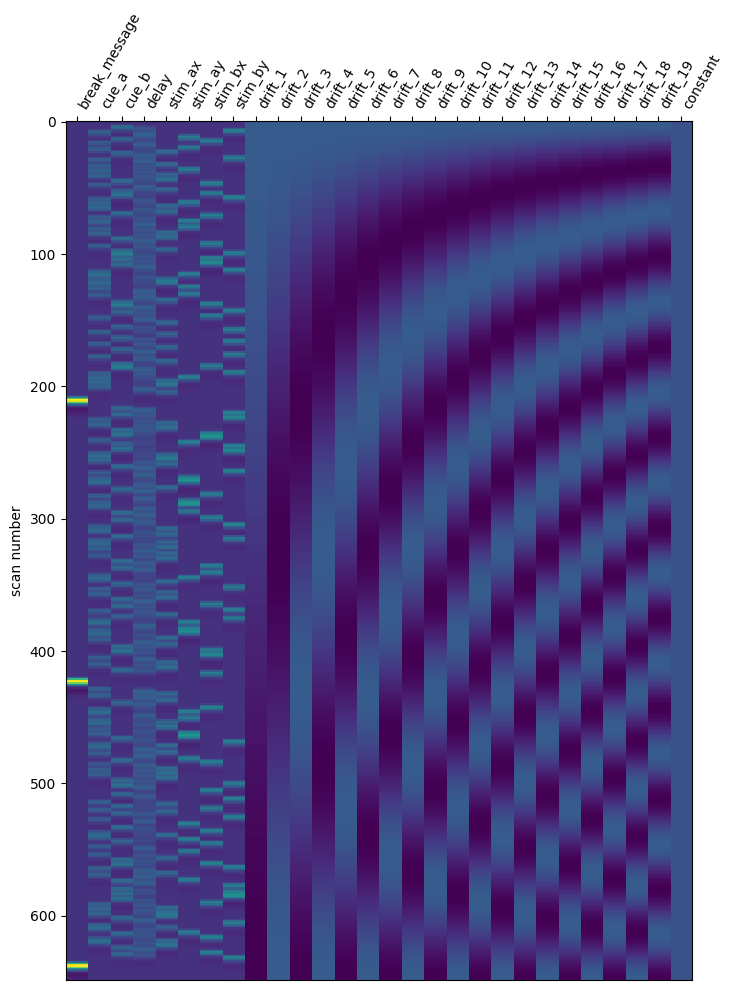

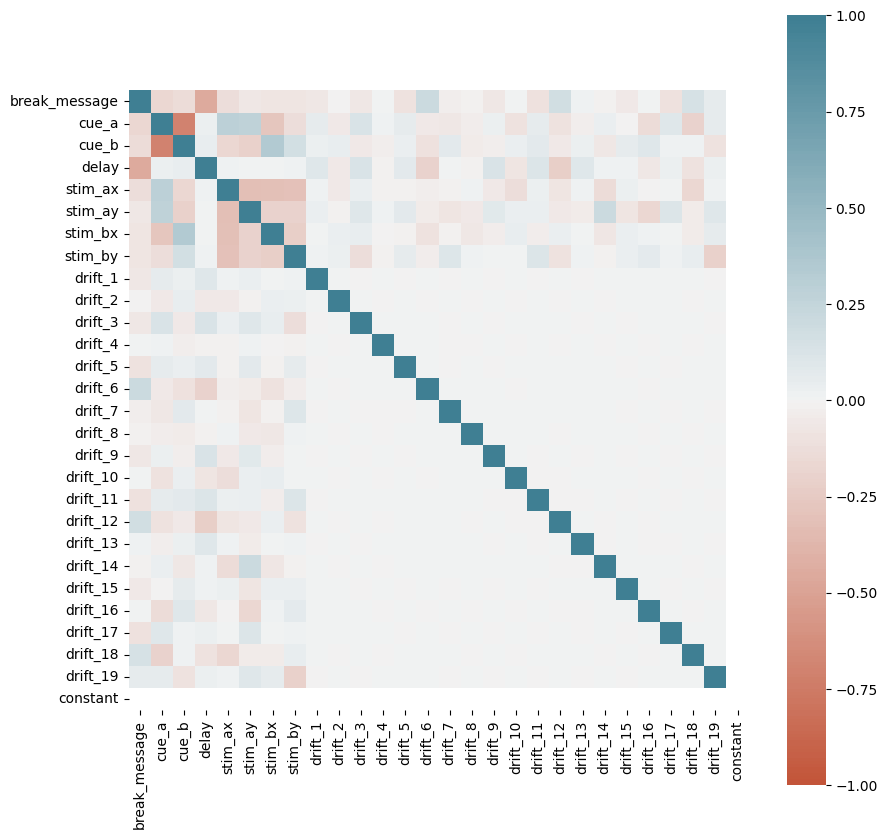

In [25]:
events_cpt_delay_jitter_no_deriv = make_ax_cpt_timings(**events_inputs_delay_jitter_no_deriv)
_, _, desmat_delay_jitter_no_deriv = est_eff_and_vif(events_cpt_delay_jitter_no_deriv, tr, total_time, contrasts, deriv=False)

plot_design_matrix(desmat_delay_jitter_no_deriv)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat_delay_jitter_no_deriv.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [26]:
nsim = 250
output_delay_jitter_no_deriv, events_delay_jitter_no_deriv = run_eff_sim(nsim, events_inputs_delay_jitter_no_deriv, make_ax_cpt_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, avg_prob_given_last1, avg_prob_given_last2, deriv=False,
                               time_past_last_offset=20)

In [27]:
eff_vif_summaries['delay jitter (1.5, 3, 4.5) no deriv']= np.round(output_delay_jitter_no_deriv[['eff_cue_a-cue_b', 'eff_stim_ay-stim_by', 
                                                         'eff_stim_bx-stim_by','eff_all_cue', 'eff_all_stim', 'eff_all_cue_stim',
                                                         'vif_cue_a-cue_b', 'vif_stim_ay-stim_by', 
                                                         'vif_stim_bx-stim_by','vif_all_cue', 'vif_all_stim', 'vif_all_cue_stim',
                                                         'scan_length']].quantile(q=[.05,.5, .95]), 2)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_cue_a-cue_b  eff_stim_ay-stim_by  eff_stim_bx-stim_by  eff_all_cue  eff_all_stim  eff_all_cue_stim  vif_cue_a-cue_b  vif_stim_ay-stim_by  vif_stim_bx-stim_by  vif_all_cue  vif_all_stim  vif_all_cue_stim  scan_length
0.05             0.26                 0.71                 1.39          0.0          0.01              0.03             3.83                 2.22                 1.09       155.60        236.50            145.20       951.72
0.50             0.27                 0.76                 1.53          0.0          0.01              0.04             3.93                 2.33                 1.14       184.41        260.47            159.81       960.93
0.95             0.28                 0.80                 1.66          0.0          0.01              0.04             4.05                 2.46                 1.24       228.90        298.49            176.35       971.64
Results for shorter delay(2s)
      eff_cue_a-cue_b  eff_stim_ay-stim_by  e

### No jitter (duration=3s) and no derivatives

In [28]:
events_inputs_delay_3_no_deriv = {
    'n_ax': 60,
    'n_ay': 30,
    'n_bx': 30,
    'n_by': 30,
    'nbreaks': 2,
    'cue_dur': .5,
    'delay_dur': 3,
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}


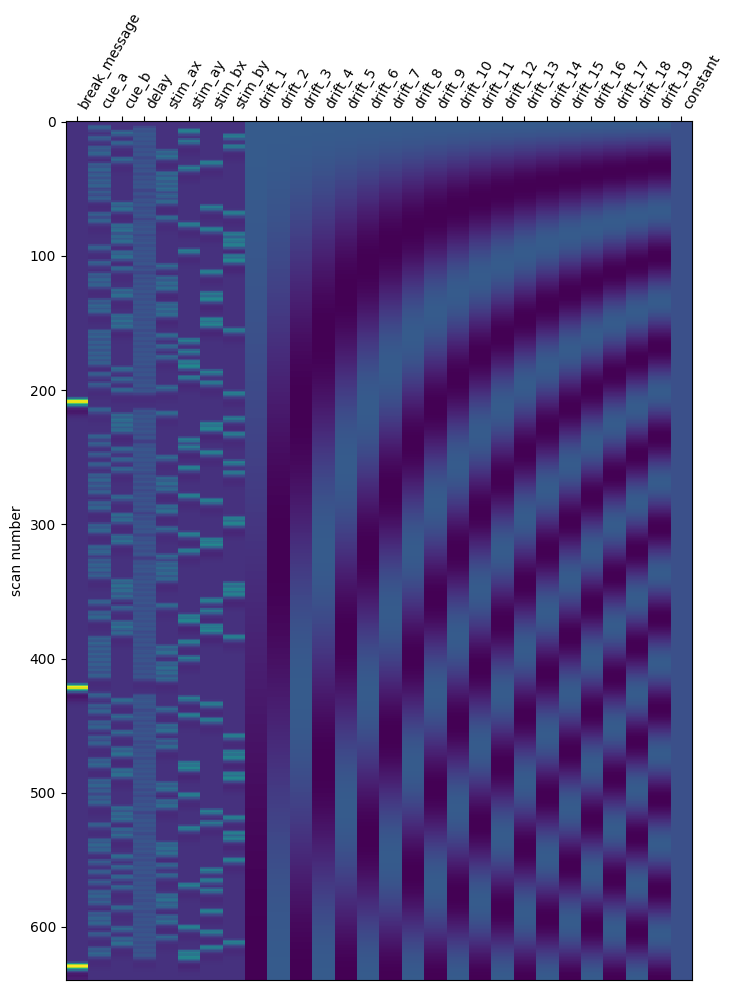

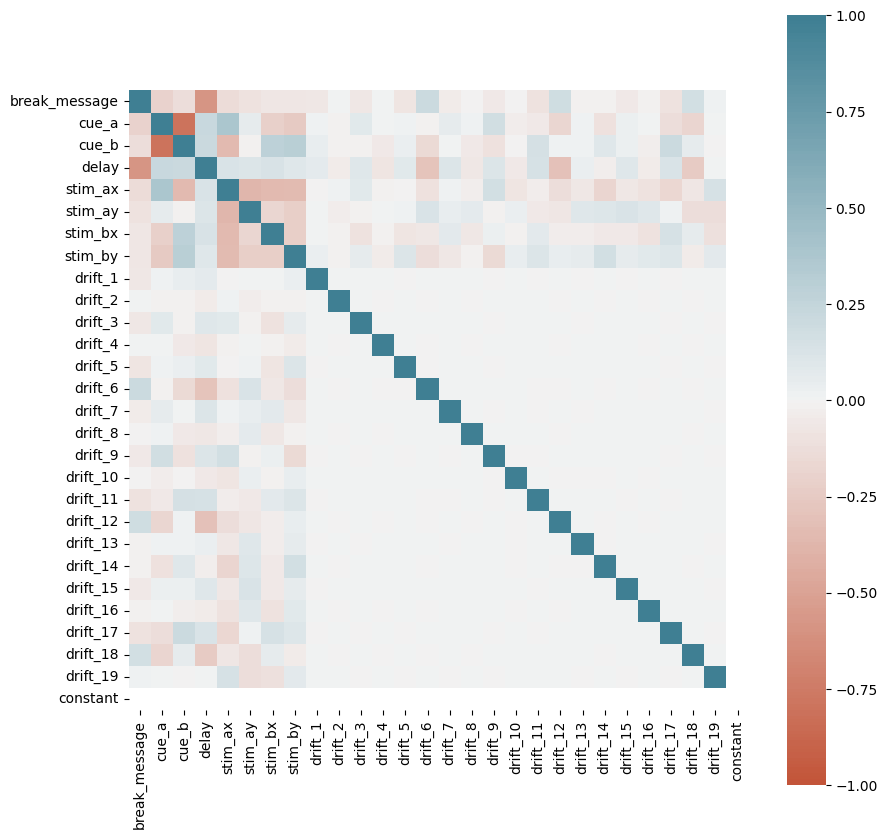

In [29]:
events_cpt_delay_3_no_deriv = make_ax_cpt_timings(**events_inputs_delay_3_no_deriv)
_, _, desmat_delay_3_no_deriv = est_eff_and_vif(events_cpt_delay_3_no_deriv, tr, total_time, contrasts, deriv=False)

plot_design_matrix(desmat_delay_3_no_deriv)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat_delay_3_no_deriv.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [30]:
nsim = 250
output_delay_3_no_deriv, events_delay_3_no_deriv = run_eff_sim(nsim, events_inputs_delay_3_no_deriv, make_ax_cpt_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, avg_prob_given_last1, avg_prob_given_last2, deriv=False,
                               time_past_last_offset=20)

In [31]:
eff_vif_summaries['delay 3 no deriv']= np.round(output_delay_3_no_deriv[['eff_cue_a-cue_b', 'eff_stim_ay-stim_by', 
                                                         'eff_stim_bx-stim_by','eff_all_cue', 'eff_all_stim', 'eff_all_cue_stim',
                                                         'vif_cue_a-cue_b', 'vif_stim_ay-stim_by', 
                                                         'vif_stim_bx-stim_by','vif_all_cue', 'vif_all_stim', 'vif_all_cue_stim',
                                                         'scan_length']].quantile(q=[.05,.5, .95]), 2)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_cue_a-cue_b  eff_stim_ay-stim_by  eff_stim_bx-stim_by  eff_all_cue  eff_all_stim  eff_all_cue_stim  vif_cue_a-cue_b  vif_stim_ay-stim_by  vif_stim_bx-stim_by  vif_all_cue  vif_all_stim  vif_all_cue_stim  scan_length
0.05             0.26                 0.71                 1.39          0.0          0.01              0.03             3.83                 2.22                 1.09       155.60        236.50            145.20       951.72
0.50             0.27                 0.76                 1.53          0.0          0.01              0.04             3.93                 2.33                 1.14       184.41        260.47            159.81       960.93
0.95             0.28                 0.80                 1.66          0.0          0.01              0.04             4.05                 2.46                 1.24       228.90        298.49            176.35       971.64
Results for shorter delay(2s)
      eff_cue_a-cue_b  eff_stim_ay-stim_by  e

In [32]:
events_inputs_delay_4_no_deriv = {
    'n_ax': 60,
    'n_ay': 30,
    'n_bx': 30,
    'n_by': 30,
    'nbreaks': 2,
    'cue_dur': .5,
    'delay_dur': 4,
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

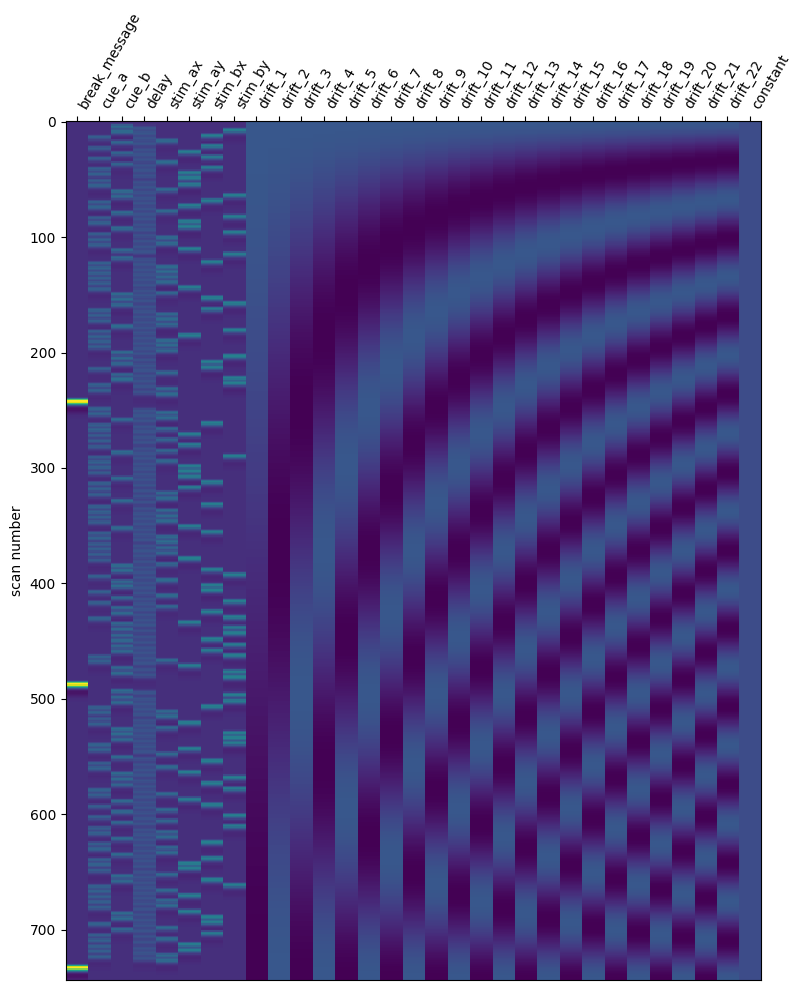

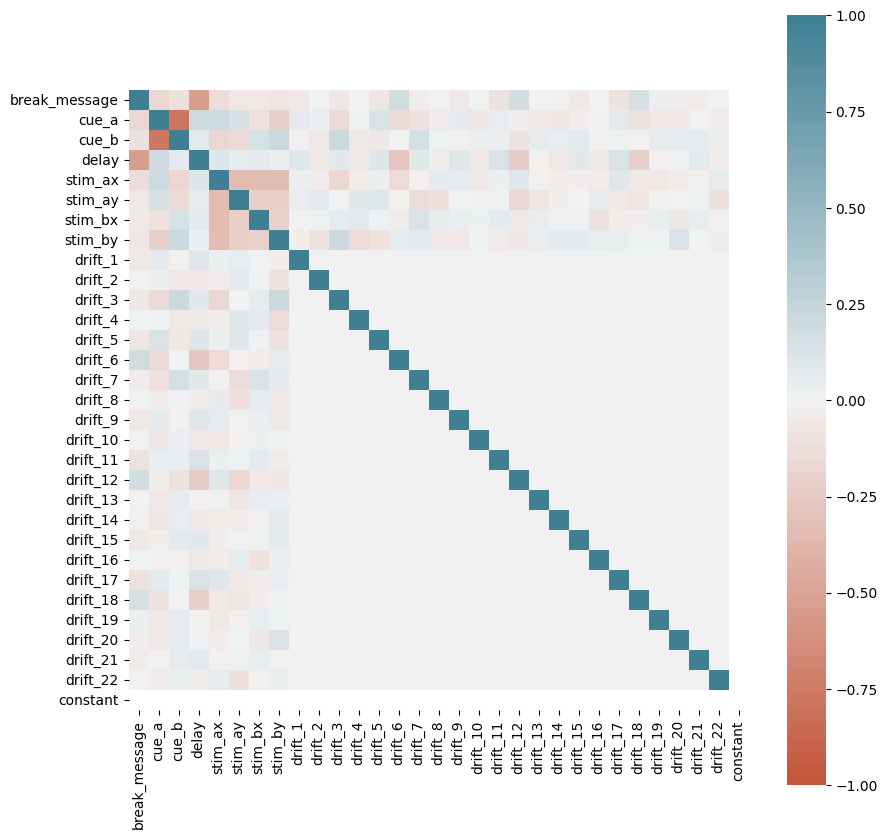

In [33]:
events_cpt_delay_4_no_deriv = make_ax_cpt_timings(**events_inputs_delay_4_no_deriv)
_, _, desmat_delay_4_no_deriv = est_eff_and_vif(events_cpt_delay_4_no_deriv, tr, total_time, contrasts, deriv=False,
                               time_past_last_offset=20)

plot_design_matrix(desmat_delay_4_no_deriv)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat_delay_4_no_deriv.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [34]:
nsim = 250
output_delay_4_no_deriv, events_delay_4_no_deriv = run_eff_sim(nsim, events_inputs_delay_4_no_deriv, make_ax_cpt_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, avg_prob_given_last1, avg_prob_given_last2, deriv=False,
                               time_past_last_offset=20)

In [35]:
eff_vif_summaries['delay 4 no deriv']= np.round(output_delay_4_no_deriv[['eff_cue_a-cue_b', 'eff_stim_ay-stim_by', 
                                                         'eff_stim_bx-stim_by','eff_all_cue', 'eff_all_stim', 'eff_all_cue_stim',
                                                         'vif_cue_a-cue_b', 'vif_stim_ay-stim_by', 
                                                         'vif_stim_bx-stim_by','vif_all_cue', 'vif_all_stim', 'vif_all_cue_stim',
                                                         'scan_length']].quantile(q=[.05,.5, .95]), 2)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_cue_a-cue_b  eff_stim_ay-stim_by  eff_stim_bx-stim_by  eff_all_cue  eff_all_stim  eff_all_cue_stim  vif_cue_a-cue_b  vif_stim_ay-stim_by  vif_stim_bx-stim_by  vif_all_cue  vif_all_stim  vif_all_cue_stim  scan_length
0.05             0.26                 0.71                 1.39          0.0          0.01              0.03             3.83                 2.22                 1.09       155.60        236.50            145.20       951.72
0.50             0.27                 0.76                 1.53          0.0          0.01              0.04             3.93                 2.33                 1.14       184.41        260.47            159.81       960.93
0.95             0.28                 0.80                 1.66          0.0          0.01              0.04             4.05                 2.46                 1.24       228.90        298.49            176.35       971.64
Results for shorter delay(2s)
      eff_cue_a-cue_b  eff_stim_ay-stim_by  e

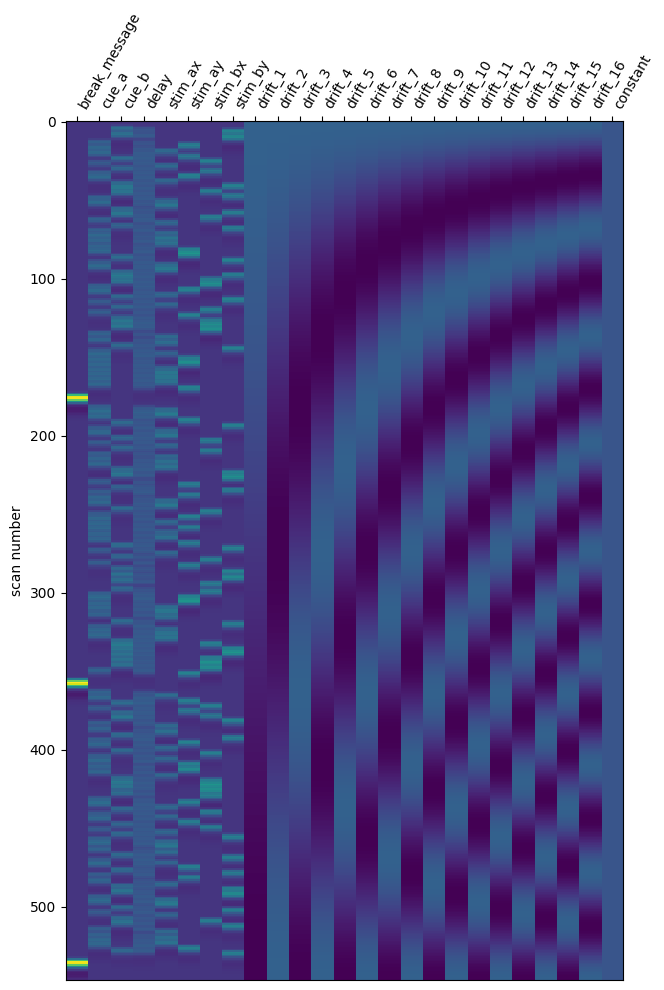

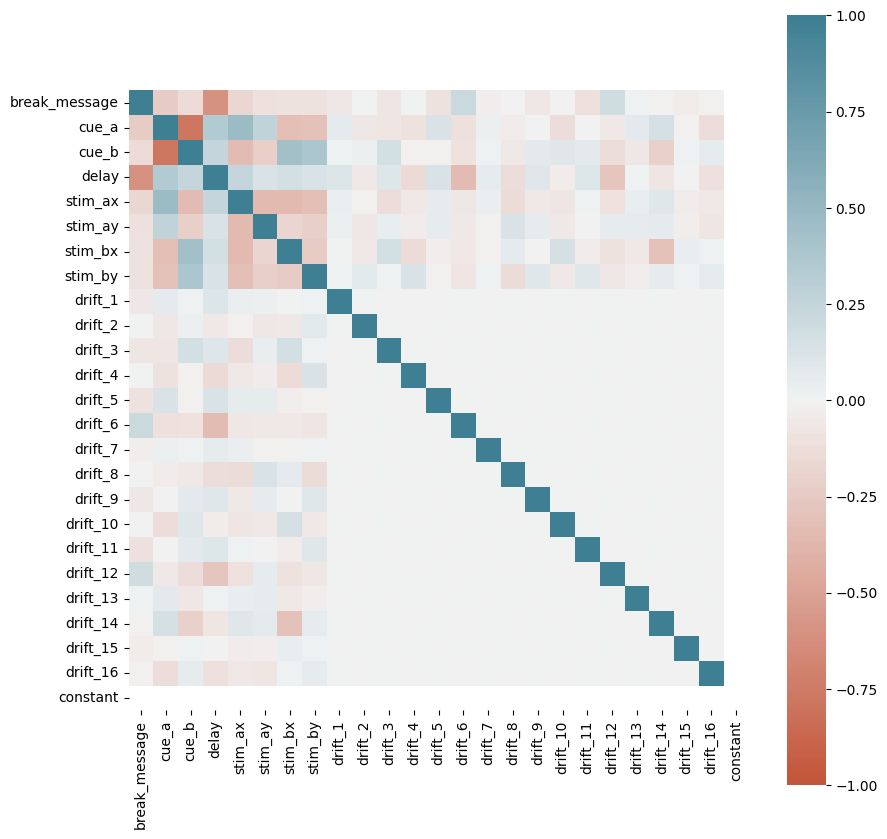

In [36]:
events_inputs_delay_2_no_deriv = {
    'n_ax': 60,
    'n_ay': 30,
    'n_bx': 30,
    'n_by': 30,
    'nbreaks': 2,
    'cue_dur': .5,
    'delay_dur': 2,
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

events_cpt_delay_2_no_deriv = make_ax_cpt_timings(**events_inputs_delay_2_no_deriv)
_, _, desmat_delay_2_no_deriv = est_eff_and_vif(events_cpt_delay_2_no_deriv, tr, total_time, contrasts, deriv=False,
                               time_past_last_offset=20)

plot_design_matrix(desmat_delay_2_no_deriv)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat_delay_2_no_deriv.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [37]:
nsim = 250
output_delay_2_no_deriv, events_delay_2_no_deriv = run_eff_sim(nsim, events_inputs_delay_2_no_deriv, make_ax_cpt_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, avg_prob_given_last1, avg_prob_given_last2, deriv=False,
                               time_past_last_offset=20)

In [38]:
eff_vif_summaries['delay 2 no deriv']= np.round(output_delay_2_no_deriv[['eff_cue_a-cue_b', 'eff_stim_ay-stim_by', 
                                                         'eff_stim_bx-stim_by','eff_all_cue', 'eff_all_stim', 'eff_all_cue_stim',
                                                         'vif_cue_a-cue_b', 'vif_stim_ay-stim_by', 
                                                         'vif_stim_bx-stim_by','vif_all_cue', 'vif_all_stim', 'vif_all_cue_stim',
                                                         'scan_length']].quantile(q=[.05,.5, .95]), 2)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_cue_a-cue_b  eff_stim_ay-stim_by  eff_stim_bx-stim_by  eff_all_cue  eff_all_stim  eff_all_cue_stim  vif_cue_a-cue_b  vif_stim_ay-stim_by  vif_stim_bx-stim_by  vif_all_cue  vif_all_stim  vif_all_cue_stim  scan_length
0.05             0.26                 0.71                 1.39          0.0          0.01              0.03             3.83                 2.22                 1.09       155.60        236.50            145.20       951.72
0.50             0.27                 0.76                 1.53          0.0          0.01              0.04             3.93                 2.33                 1.14       184.41        260.47            159.81       960.93
0.95             0.28                 0.80                 1.66          0.0          0.01              0.04             4.05                 2.46                 1.24       228.90        298.49            176.35       971.64
Results for shorter delay(2s)
      eff_cue_a-cue_b  eff_stim_ay-stim_by  e

### What if we jitter around 2s?

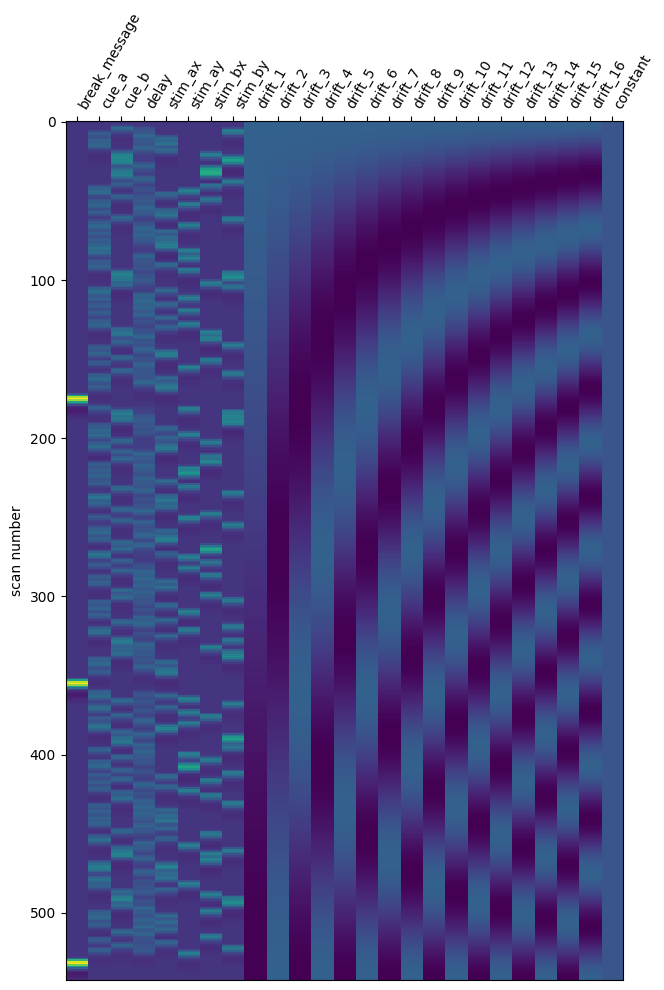

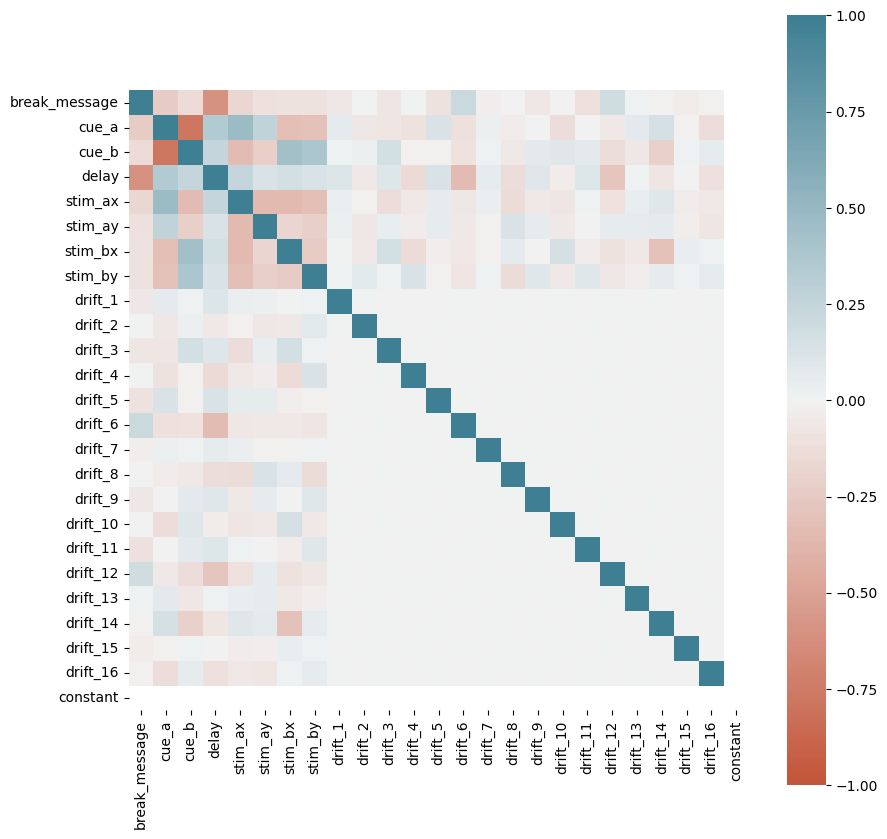

In [39]:
events_inputs_delay_jitter2_noderiv = {
    'n_ax': 60,
    'n_ay': 30,
    'n_bx': 30,
    'n_by': 30,
    'nbreaks': 2,
    'cue_dur': .5,
    'delay_dur': 'jittered2',
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

events_cpt_delay_jitter2_no_deriv = make_ax_cpt_timings(**events_inputs_delay_jitter2_noderiv)
_, _, desmat_delay_jitter2_no_deriv = est_eff_and_vif(events_cpt_delay_jitter2_no_deriv, tr, total_time, contrasts, deriv=False,
                               time_past_last_offset=20)

plot_design_matrix(desmat_delay_jitter2_no_deriv)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat_delay_2_no_deriv.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [40]:
nsim = 250
output_delay_jitter2_noderiv, events_delay_jitter2_noderiv = run_eff_sim(nsim, events_inputs_delay_jitter2_noderiv, make_ax_cpt_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, avg_prob_given_last1, avg_prob_given_last2, deriv=False,
                               time_past_last_offset=20)

In [41]:
eff_vif_summaries['delay 2 jittered (.5,2,3.5) no deriv']= np.round(output_delay_jitter2_noderiv[['eff_cue_a-cue_b', 'eff_stim_ay-stim_by', 
                                                         'eff_stim_bx-stim_by','eff_all_cue', 'eff_all_stim', 'eff_all_cue_stim',
                                                         'vif_cue_a-cue_b', 'vif_stim_ay-stim_by', 
                                                         'vif_stim_bx-stim_by','vif_all_cue', 'vif_all_stim', 'vif_all_cue_stim',
                                                         'scan_length']].quantile(q=[.05,.5, .95]), 2)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_cue_a-cue_b  eff_stim_ay-stim_by  eff_stim_bx-stim_by  eff_all_cue  eff_all_stim  eff_all_cue_stim  vif_cue_a-cue_b  vif_stim_ay-stim_by  vif_stim_bx-stim_by  vif_all_cue  vif_all_stim  vif_all_cue_stim  scan_length
0.05             0.26                 0.71                 1.39          0.0          0.01              0.03             3.83                 2.22                 1.09       155.60        236.50            145.20       951.72
0.50             0.27                 0.76                 1.53          0.0          0.01              0.04             3.93                 2.33                 1.14       184.41        260.47            159.81       960.93
0.95             0.28                 0.80                 1.66          0.0          0.01              0.04             4.05                 2.46                 1.24       228.90        298.49            176.35       971.64
Results for shorter delay(2s)
      eff_cue_a-cue_b  eff_stim_ay-stim_by  e

### The chosen design, but only allowing 10s at the end

In [ ]:
events_inputs_delay_jitter_no_deriv = {
    'n_ax': 60,
    'n_ay': 30,
    'n_bx': 30,
    'n_by': 30,
    'nbreaks': 2,
    'cue_dur': .5,
    'delay_dur': 'jittered3',
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

In [42]:
nsim = 250
output_delay_jitter_no_deriv_10s_end, events_delay_jitter_no_deriv_10s_end = run_eff_sim(nsim, events_inputs_delay_jitter_no_deriv, make_ax_cpt_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map, avg_prob_given_last1, avg_prob_given_last2, deriv=False,
                               time_past_last_offset=10)

In [45]:
#'delay jitter (1.5, 3, 4.5) no deriv'

eff_vif_summaries['delay jitter (1.5, 3, 4.5) no deriv, 10s end']= np.round(output_delay_jitter_no_deriv_10s_end[['eff_cue_a-cue_b', 'eff_stim_ay-stim_by', 
                                                         'eff_stim_bx-stim_by','eff_all_cue', 'eff_all_stim', 'eff_all_cue_stim',
                                                         'vif_cue_a-cue_b', 'vif_stim_ay-stim_by', 
                                                         'vif_stim_bx-stim_by','vif_all_cue', 'vif_all_stim', 'vif_all_cue_stim',
                                                         'scan_length']].quantile(q=[.05,.5, .95]), 2)

vals = ['delay jitter (1.5, 3, 4.5) no deriv', 'delay jitter (1.5, 3, 4.5) no deriv, 10s end']
for val in vals:
    print(f'Results for {key}')
    print(eff_vif_summaries[val])

Results for delay 2 jittered (.5,2,3.5) no deriv
      eff_cue_a-cue_b  eff_stim_ay-stim_by  eff_stim_bx-stim_by  eff_all_cue  eff_all_stim  eff_all_cue_stim  vif_cue_a-cue_b  vif_stim_ay-stim_by  vif_stim_bx-stim_by  vif_all_cue  vif_all_stim  vif_all_cue_stim  scan_length
0.05             0.70                 1.30                 1.43         0.42          1.59              2.33             1.24                 1.13                 1.08         1.81          2.13              2.67       952.13
0.50             0.78                 1.43                 1.56         0.45          1.73              2.62             1.35                 1.22                 1.13         1.91          2.27              2.90       963.07
0.95             0.85                 1.56                 1.67         0.49          1.88              2.89             1.52                 1.34                 1.21         2.01          2.42              3.21       974.58
Results for delay 2 jittered (.5,2,3.5) no deri